# Framework for Strategy I (S1)

# Data import and pre-processing

In [9]:
# import python libraries
import pandas as pd
import numpy as np
import datetime as dt
import os

In [10]:
# First, define date range for data of interest. In this experiment, I am interested to analysis 1 year worth of data
start_date = pd.to_datetime('2022-04-01')
end_date = pd.to_datetime('2023-05-31')

In [11]:
# feature functions for age group
def age_group_range(age):
    if age < 18:
        return 'age_group_0_to_17'
    elif age < 35:
        return 'age_group_18_to_34'
    elif age < 50:
        return 'age_group_35_to_49'
    elif age < 65:
        return 'age_group_50_to_64'
    else:
        return 'age_group_above_65'

In [14]:
# import data
# Define the relative path to the data file
data_path = './data/healthcare_dataset.csv'

# Load the CSV file
df = pd.read_csv(data_path)

# convert date in string type to datetime
date_col = ['Date of Admission', 'Discharge Date']
for col in date_col:
    df[col] = pd.to_datetime(df[col])

# add end of month columns for date field
df['admission_EOM_date'] = df['Date of Admission'].apply(lambda x: x + pd.offsets.MonthEnd(0))
df['discharge_EOM_date'] = df['Discharge Date'].apply(lambda x: x + pd.offsets.MonthEnd(0))

# add encounter_id 
df['encounter_id'] = df.index + 101

df['age_group'] = df['Age'].apply(lambda x: age_group_range(x))

# compute LOS
df['length_of_stay'] = (df['Discharge Date'] - df['Date of Admission']).dt.days

# subset data based on date range
df = df[(df['Date of Admission']>=start_date) & (df['Date of Admission']<end_date)]

# Compute descriptive metrics

In [15]:
## Overview metrics

# Number of encounters
total_encounter_count = df['encounter_id'].nunique()
# Number of patients
total_patient_count = df['Name'].nunique()

## Utilization Metrics

# Distribution by Age
age_dist = df.groupby('age_group')['encounter_id'].size().reset_index().rename(columns={'encounter_id':'encounterCount'}).to_string()
# Distribution by Gender
gender_dist = df.groupby('Gender')['encounter_id'].size().reset_index().rename(columns={'encounter_id':'encounterCount'}).to_string()
# - Distribution by Medical Condition
condition_dist = df.groupby('Medical Condition')['encounter_id'].size().reset_index().rename(columns={'encounter_id':'encounterCount'}).to_string()
# - Distrituion Admission Type
admit_dist = df.groupby('Admission Type')['encounter_id'].size().reset_index().rename(columns={'encounter_id':'encounterCount'}).to_string()
# - Distribution Medication
med_dist = df.groupby('Medication')['encounter_id'].size().reset_index().rename(columns={'encounter_id':'encounterCount'}).to_string()
# - Distribution by Insurance Provider
ins_dist = df.groupby('Insurance Provider')['encounter_id'].size().reset_index().rename(columns={'encounter_id':'encounterCount'}).to_string()

## Financial Metrics

# Total Billing Amount
total_bill_amount = df['Billing Amount'].sum()
# Total Bill Amount by Condition
total_amount_by_cond = df.groupby('Medical Condition')['Billing Amount'].sum().reset_index().rename(columns={'Billing Amount':'total_bill_amount'}).to_string()
# Total Bill Amount by Medical Condition
total_amount_by_med = df.groupby('Medication')['Billing Amount'].sum().reset_index().rename(columns={'Billing Amount':'total_bill_amount'}).to_string()
# Avg Bill Amount by encounter
avg_enc_amount = df['Billing Amount'].sum()/df['encounter_id'].nunique()
# Median Bill Amount by encounter
median_enc_amount = df['Billing Amount'].median()



## Generating Summary Output for Descriptive Analysis

In [25]:
descriptive_summary = f"Section 1: Descriptive analytics\n\
Analysis was conduction with data between {start_date.strftime('%Y-%m-%d')} and {end_date.strftime('%Y-%m-%d')}\n\n\
Overview analysis\n\
- Number of hospital admission = {total_encounter_count}\n\
- Distribution by encounter by age groups:\n\
    {age_dist}\n\n\
- Distribution by encounter by gender:\n\
    {gender_dist}\n\n\
Utilization analysis\n\
- Distribution by encounter by medical conditions:\n\
    {condition_dist}\n\n\
- Distribution by encounter by admission types:\n\
    {admit_dist}\n\n\
- Distribution by encounter by medications:\n\
    {med_dist}\n\n\
- Distribution by encounter by insurance providers:\n\
    {ins_dist}\n\n\
Financial analysis\n\
- Total bill amount = ${total_bill_amount:.2f}\n\
- Average bill amount per encounter = ${avg_enc_amount:.2f}\n\
- Median bill amount per encounter = ${median_enc_amount:.2f}\n\
- Distribution by total bill amount by medical condition:\n\
    {total_amount_by_cond}\n\n\
- Distribution by total bill amount by medication:\n\
    {total_amount_by_med}"

print(descriptive_summary)

Section 1: Descriptive analytics
Analysis was conduction with data between 2022-04-01 and 2023-05-31

Overview analysis
- Number of hospital admission = 12863
- Distribution by encounter by age groups:
                age_group  encounterCount
0   age_group_0_to_17              34
1  age_group_18_to_34            3132
2  age_group_35_to_49            2830
3  age_group_50_to_64            2936
4  age_group_above_65            3931

- Distribution by encounter by gender:
       Gender  encounterCount
0  Female            6433
1    Male            6430

Utilization analysis
- Distribution by encounter by medical conditions:
      Medical Condition  encounterCount
0         Arthritis            2182
1            Asthma            2066
2            Cancer            2176
3          Diabetes            2223
4      Hypertension            2137
5           Obesity            2079

- Distribution by encounter by admission types:
      Admission Type  encounterCount
0       Elective            4

# Statistical analytics
1) Hypothesis test with T-test
2) Correlation
3) Forecasting

### T-test

In [18]:
# Hypothesis: Encounter with abnormal or inconclusive test result has higher billing amount per encounter
# Statistically significant value: P-value < 0.05 

from scipy.stats import ttest_ind

insurance_provider_list = df['Insurance Provider'].unique()
res_df = pd.DataFrame()
for ins in insurance_provider_list:
    res = pd.DataFrame({'insurance_provider':ins}, index=[0])
    cohort_a = df[
        (df['Test Results']!='Normal') &
        (df['Insurance Provider']==ins)]
    cohort_b = df[
        (df['Test Results']=='Normal') &
        (df['Insurance Provider']==ins)]
    stat_ttest, p_ttest = ttest_ind(cohort_a['Billing Amount'], cohort_b['Billing Amount'])
    res['t_test_stat'] = stat_ttest
    res['p_value'] = p_ttest
    res['mean_bill_amount_reference'] = round(cohort_b['Billing Amount'].mean(),0)
    res['mean_bill_amount_target'] = round(cohort_a['Billing Amount'].mean(),0)
    res['percent_deviate'] = round((res['mean_bill_amount_target']-res['mean_bill_amount_reference'])/res['mean_bill_amount_reference']*100,2)
    res['change_direction'] = np.where(res['percent_deviate']<0, 'lower', 
                                       np.where(res['percent_deviate']>0, 'higher', 'no change'))

    res_df = pd.concat([res_df, res])

ttest_string_df = res_df.to_string()

    

### Correlation Coefficient

In [33]:
import itertools

continuous_var = ['Age', 'Billing Amount', 'length_of_stay']
pair_var_list = list(itertools.combinations(continuous_var, 2))

corr_res = pd.DataFrame()
for cols in pair_var_list:
    res = pd.DataFrame({
        'var_1':cols[0],
        'var_2':cols[1],
        'correlation_coefficient': df[cols[0]].corr(df[cols[1]])
        }, index=[0])
    corr_res = pd.concat([corr_res, res])

corr_res['direction'] = np.where(corr_res['correlation_coefficient']<0, 'negatively correlated', 'positively correlated')
corr_res_string = corr_res.to_string()

### Forecasting with ARIMA

/Users/jasmine/opt/anaconda3/envs/anaconda_py311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/jasmine/opt/anaconda3/envs/anaconda_py311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/jasmine/opt/anaconda3/envs/anaconda_py311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/jasmine/opt/anaconda3/envs/anaconda_py311/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parame

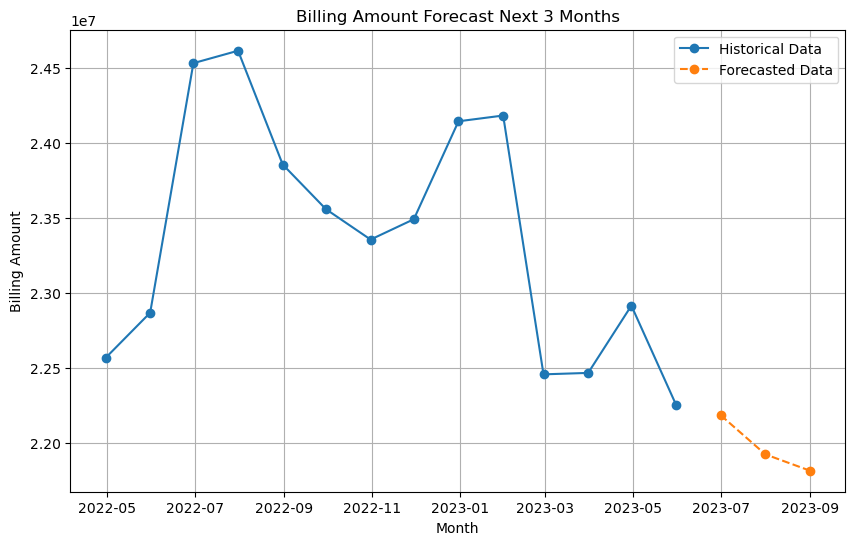

In [20]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

arima_df = df.groupby('admission_EOM_date')['Billing Amount'].sum().reset_index().sort_values('admission_EOM_date')
arima_df['admission_EOM_date'] = pd.to_datetime(arima_df['admission_EOM_date'])
arima_df.set_index('admission_EOM_date', inplace=True)

# Build and Fit ARIMA Model
model = ARIMA(arima_df['Billing Amount'], order=(2, 1, 2))  # Order can be fine-tuned
fitted_model = model.fit()

# Forecast the next 3 months
forecast_steps = 3
forecast = fitted_model.forecast(steps=forecast_steps)

# Create forecast dates
forecast_dates = pd.date_range(arima_df.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='MS')

# Combine historical data and forecast
forecast_df = pd.DataFrame({
    "Month": forecast_dates,
    "forecasted_billing_amount": forecast.values
})
forecast_df.set_index("Month", inplace=True)

# Visualize forecast
plt.figure(figsize=(10, 6))
plt.plot(arima_df.index, arima_df['Billing Amount'], marker='o', label="Historical Data")
plt.plot(forecast_df.index, forecast_df['forecasted_billing_amount'], marker='o', label="Forecasted Data", linestyle='--')
plt.title("Billing Amount Forecast Next 3 Months")
plt.xlabel("Month")
plt.ylabel("Billing Amount")
plt.grid()
plt.legend()
plt.show()

# Print Forecasted Values
forecast_df = forecast_df.reset_index()
forecast_df_string = forecast_df.to_string()


## Generating Summary Output for Statistical Analysis

In [34]:
advanced_analytics_summary = f"Section 2: Advanced analytics\n\
Advanced analysis was conduction with data between {start_date.strftime('%Y-%m-%d')} and {end_date.strftime('%Y-%m-%d')}\n\n\
Hypothesis: Encounter with abnormal or inconclusive test result is statistical signficantly higher in billing amount per encounter\n\
Statistically significant if P-value < 0.05 \n\
- Result table to test for billing amount being higher for patients with abnormal or inconclusive test result:\n\n\
    {ttest_string_df}\n\n\
Correlation between continuous variables\n\
- Result table to measure correlation between two continuous variables:\n\n\
    {corr_res_string}\n\n\
Forecast of billing amount for the next three months\n\
- Result table to forecast for billing amount for the next three months:\n\n\
    {forecast_df_string}"

print(advanced_analytics_summary)

Section 2: Advanced analytics
Advanced analysis was conduction with data between 2022-04-01 and 2023-05-31

Hypothesis: Encounter with abnormal or inconclusive test result is statistical signficantly higher in billing amount per encounter
Statistically significant if P-value < 0.05 
- Result table to test for billing amount being higher for patients with abnormal or inconclusive test result:

      insurance_provider  t_test_stat   p_value  mean_bill_amount_reference  mean_bill_amount_target  percent_deviate change_direction
0              Aetna     0.348002  0.727869                     25507.0                  25718.0             0.83           higher
0         Blue Cross    -0.948517  0.342958                     25615.0                  25049.0            -2.21            lower
0              Cigna     0.787035  0.431332                     25146.0                  25616.0             1.87           higher
0   UnitedHealthcare     0.525994  0.598937                     25229.0     

# Final prompts generation

In [27]:
# Setup final PROMPT
PROMPT_ = f"""
Write me a summary describing the finding of inpatient hospital data for a selection year. 
There are two sections of analysis with section 1 as descriptive and section 2 as advanced analytics.
In the report, make sure
- Highilght the time range for the analysis
- Start with Highlights of analysis in bullet points with most interesting insights identified in the analysis
- Follow up by in-depth analysis for each of the sections by providing apprepropriate context for each measurements
- For Descriptive analysis, extract interesting insights for each metrics such as highest, lowest, percent deviation, fold changes etc.
- For Advanced analytics, extract statistically significant interesting insights for each metrics. Report exact numbers of forecasted amount.
- Conclude findings with areas of attentions.  
Here is the analytics output:
{descriptive_summary}

{advanced_analytics_summary}
"""

SYSTEMS_="""
You are an analyst writing a report based on metrics computed, derive insights and findings for reporting. 
    Output response in HTML format with title and subtitiles
"""

# LLM Model setup

In [29]:
import openai
import os
from dotenv import load_dotenv

load_dotenv()
# Function to make an API call to OpenAI's GPT model
openai_api_key = os.getenv('OPENAI_API_KEY')

def generate_response(text, system):

    """
    Function to send a prompt to OpenAI and receive a response.
    
    :param prompt: Text input for the OpenAI model.
    :param model: Model to use, e.g., "gpt-3.5-turbo" or "gpt-4".
    :param max_tokens: Maximum number of tokens in the response.
    :return: Response text from the OpenAI model.
    """
    
    # Set your OpenAI API key
    openai.api_key = f'{openai_api_key}'
    
    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": text}

    ]
    try:
        response = openai.chat.completions.create(
            model="gpt-4",
            messages = messages
        )
    
        return response.choices[0].message.content.strip()
    
    except openai.OpenAIError as e:
        print(f"An error occurred: {e}")
        
        return None


## Execute LLM model

In [30]:
result = generate_response(PROMPT_, SYSTEMS_)
print("AI Response:", result)

AI Response: <html>
<head>
</head>
<body>
<h1>Report on Inpatient Hospital Data Analysis</h1>

<p>The report consists of two sections: descriptive analytics and advanced analytics. These analyses were done over the timeframe of 1st April 2022 to 31st May 2023.</p>

<h2>Highlights of the Analysis</h2>
<ul>
    <li>A total of 12,863 hospital admissions were registered</li>
    <li>The majority of hospital encounters were for patients aged above 65 (3,931 encounters)</li>
    <li>Admission distribution is almost equal in terms of gender</li>
    <li>Diabetes was the most common medical condition (2,223 encounters) causing hospitalizations</li>
    <li>The most common admission type was elective (4,384 encounters)</li>
    <li>Aspirin was the most commonly prescribed medication (2,630 encounters)</li>
    <li>Medicare was the largest insurance provider (2,667 encounters)</li>
    <li>A total of $327,244,994.55 was billed over the one-year period</li>
</ul>

<h2>Descriptive Analysis</h2>
<h

# Results deliveries

## export as HTML file

In [31]:
# Save the HTML to a file
output_file = "healthcare_yearly_report.html"
with open(output_file, "w") as file:
    file.write(result)

# Provide a message with the file location
print(f"HTML file saved at: {os.path.abspath(output_file)}")

HTML file saved at: /Users/jasmine/Documents/data_science_project/LLM_reporting/healthcare_yearly_report.html


## Generate email content with HTML file and deliver via SendGrid

In [32]:
import os
from sendgrid import SendGridAPIClient
from sendgrid.helpers.mail import Mail

def send_test_email(to_email):
    message = Mail(
        from_email='{insert your email here}',
        to_emails=to_email,
        subject='Please review Inpatient hospitalization analysis',
        html_content=result
    )
        # html_content='<strong>This is a test email sent with SendGrid and Python.</strong>'

    try:
        sg = SendGridAPIClient(os.environ.get('SENDGRID_API_KEY'))
        response = sg.send(message)
        print("Email sent successfully:", response.status_code)
    except Exception as e:
        print("Error sending email:", e)

if __name__ == "__main__":
    to_email = input("Enter the email address to send the test email: ")
    send_test_email(to_email)

Email sent successfully: 202
